In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# load data
df = pd.read_csv('agentdata/rssi_sl_raw_long.csv')

In [4]:
mcs = [ 'BPSK 1/2', 'BPSK 3/4', 'QPSK 1/2', 'QPSK 3/4',
        '16QAM 1/2', '16QAM 3/4', '64QAM 2/3', '64QAM 3/4']

In [5]:
# get dataset of best action for each observation (obs and label)
cols = []
for i in range(64):
    cols.append('Sc' + str(i))

df['Run'] = df.apply(lambda row: int(row.name / 8), axis=1)
df = df[df['Reward'] > 0.0]

obs = []
label = []
dist = []
maxrewards = []

for run in df['Run'].unique():
    runData = df[df['Run'] == run]
    myid = runData['Reward'].idxmax()
    myrow = df.loc[myid]
    label.append(myrow['Action'])
    maxrewards.append(myrow['Reward'])
    obs.append(myrow[cols].to_numpy())
    dist.append(myrow['Dist'])
    df.loc[df.Run == run, "Best"] = myrow['Action']

In [6]:
np.power(np.array(maxrewards) / max(maxrewards), 0.2)

array([0.9641925 , 0.9641925 , 0.9563525 , ..., 0.48454357, 0.36422947,
       0.43748491])

In [7]:
a_size = 8
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=(1,), activation='sigmoid'))
model.add(keras.layers.Dense(a_size*2, activation='relu'))
model.add(keras.layers.Dense(a_size, activation='relu'))
model.add(keras.layers.Dense(a_size, activation='softmax'))
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
Total params: 242
Trainable params: 242
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# take average observation over all 64 subcarriers
data = []
for elem in obs:
    elem = np.average([elem[11], elem[25], elem[39], elem[53]])
    elem = (elem - 0) / 45 
    elem = np.reshape(elem, [1, ])
    data.append(elem)
data = np.array(data)

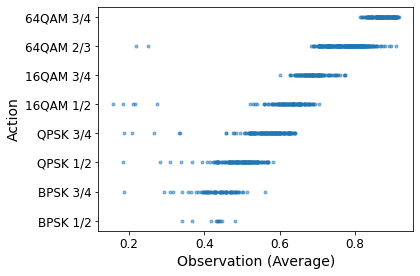

In [18]:
plt.plot(data, label, '.', alpha = 0.5)
plt.yticks(range(8), mcs)
plt.xlabel('Observation (Average)')
plt.ylabel('Action')
plt.tight_layout()
plt.savefig('eval_action.pdf')
plt.savefig('eval_action.png')

In [10]:
# randomize data
new_data = data
new_label =[]
new_label.extend(label)

for i in range(5):
    new_data = np.append(new_data, data + np.random.normal(0,0.005,len(data)).reshape(len(data),1))
    new_label.extend(label)
len(new_data)

6594

In [11]:
total_epochs = int(100)
model.fit(new_data, new_label,
                validation_split=0.2,
                epochs=total_epochs,
                batch_size=32)

Train on 5275 samples, validate on 1319 samples
Epoch 1/100
5275/5275 [==============================] - 1s 165us/sample - loss: 2.0550 - acc: 0.1378 - val_loss: 2.0204 - val_acc: 0.1440
Epoch 2/100
5275/5275 [==============================] - 0s 83us/sample - loss: 1.9836 - acc: 0.1484 - val_loss: 1.9497 - val_acc: 0.2578
Epoch 3/100
5275/5275 [==============================] - 0s 76us/sample - loss: 1.9244 - acc: 0.2620 - val_loss: 1.9106 - val_acc: 0.2578
Epoch 4/100
5275/5275 [==============================] - 0s 74us/sample - loss: 1.9040 - acc: 0.2620 - val_loss: 1.9007 - val_acc: 0.2578
Epoch 5/100
5275/5275 [==============================] - 0s 69us/sample - loss: 1.8972 - acc: 0.2620 - val_loss: 1.8946 - val_acc: 0.2578
Epoch 6/100
5275/5275 [==============================] - 0s 75us/sample - loss: 1.8890 - acc: 0.2620 - val_loss: 1.8846 - val_acc: 0.2578
Epoch 7/100
5275/5275 [==============================] - 0s 77us/sample - loss: 1.8756 - acc: 0.2620 - val_loss: 1.8665 - v

5275/5275 [==============================] - 0s 68us/sample - loss: 0.7363 - acc: 0.6904 - val_loss: 0.7263 - val_acc: 0.7028
Epoch 60/100
5275/5275 [==============================] - 0s 74us/sample - loss: 0.7360 - acc: 0.6916 - val_loss: 0.7280 - val_acc: 0.7005
Epoch 61/100
5275/5275 [==============================] - 0s 74us/sample - loss: 0.7343 - acc: 0.6906 - val_loss: 0.7226 - val_acc: 0.7149
Epoch 62/100
5275/5275 [==============================] - 0s 70us/sample - loss: 0.7330 - acc: 0.6927 - val_loss: 0.7235 - val_acc: 0.7066
Epoch 63/100
5275/5275 [==============================] - 0s 73us/sample - loss: 0.7331 - acc: 0.6914 - val_loss: 0.7220 - val_acc: 0.7172
Epoch 64/100
5275/5275 [==============================] - 0s 71us/sample - loss: 0.7334 - acc: 0.6912 - val_loss: 0.7217 - val_acc: 0.7104
Epoch 65/100
5275/5275 [==============================] - 0s 70us/sample - loss: 0.7315 - acc: 0.6918 - val_loss: 0.7199 - val_acc: 0.7005
Epoch 66/100
5275/5275 [================

In [12]:
for test in [0.4, 0.5, 0.6, 0.7]:
    var = model.predict([test])
    print(str(test) +" -> " + str(np.argmax(var)))

0.4 -> 1
0.5 -> 2
0.6 -> 3
0.7 -> 5


In [13]:
dfDist = pd.DataFrame(data, columns =['Avg'])
dfDist['Dist'] = dist

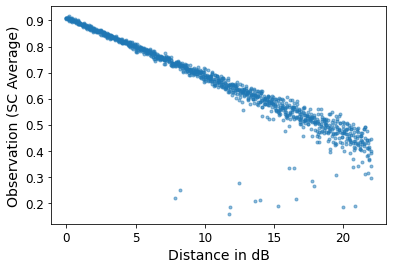

In [14]:
plt.plot(dist, data, '.', alpha = 0.5)
plt.xlabel('Distance in dB')
plt.ylabel('Observation (SC Average)')
plt.savefig('eval_observation.pdf')
plt.savefig('eval_observation.png')

In [15]:
df

,Unnamed: 0,Sc0,Sc1,Sc2,Sc3,Sc4,Sc5,Sc6,Sc7,Sc8,...,Sc59,Sc60,Sc61,Sc62,Sc63,Dist,Action,Reward,Run,Best
0,0,0.0,0.0,0.0,0.0,0.0,0.0,20.022800,20.276606,16.465090,...,0.0,0.0,0.0,0.0,0.0,0.000000,0,0.900000,0,7.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,40.809376,40.955044,41.681637,...,0.0,0.0,0.0,0.0,0.0,0.000000,1,1.000000,0,7.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,40.634106,40.674774,41.103321,...,0.0,0.0,0.0,0.0,0.0,0.000000,2,2.500000,0,7.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,40.306149,40.922256,41.328854,...,0.0,0.0,0.0,0.0,0.0,0.000000,3,3.750000,0,7.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,40.521397,41.090179,41.462837,...,0.0,0.0,0.0,0.0,0.0,0.000000,4,4.800000,0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8777,0,0.0,0.0,0.0,0.0,0.0,0.0,17.507910,22.739927,16.035513,...,0.0,0.0,0.0,0.0,0.0,21.799087,1,0.480769,1097,1.0
8784,0,0.0,0.0,0.0,0.0,0.0,0.0,18.755621,16.173264,19.881615,...,0.0,0.0,0.0,0.0,0.0,21.899543,0,0.115385,1098,0.0
8785,0,0.0,0.0,0.0,0.0,0.0,0.0,13.268126,9.988312,19.262566,...,0.0,0.0,0.0,0.0,0.0,21.899543,1,0.096154,1098,0.0
8792,0,0.0,0.0,0.0,0.0,0.0,0.0,20.947643,21.412361,24.553719,...,0.0,0.0,0.0,0.0,0.0,22.000000,0,0.125000,1099,1.0


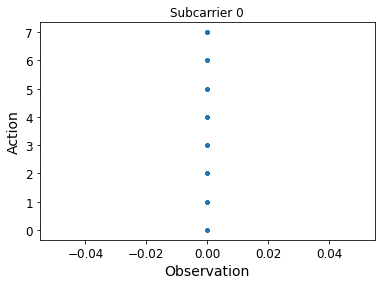

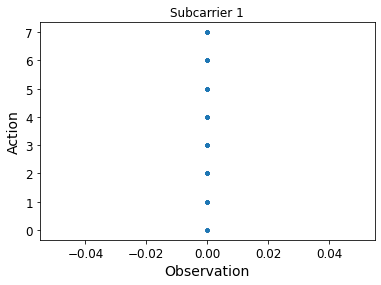

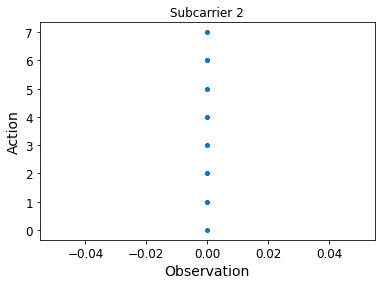

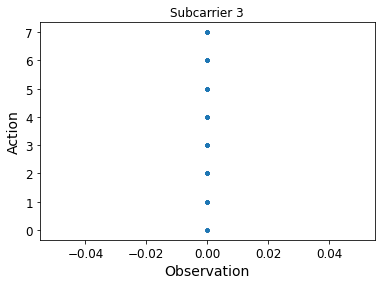

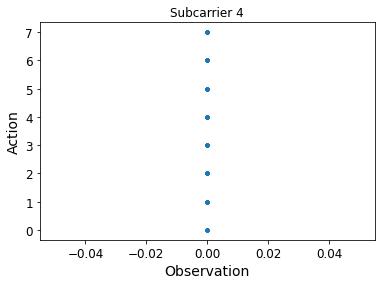

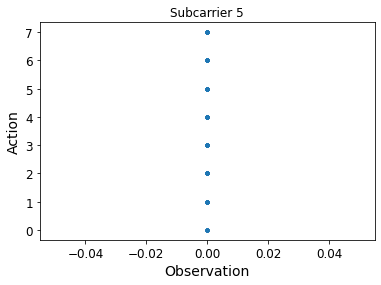

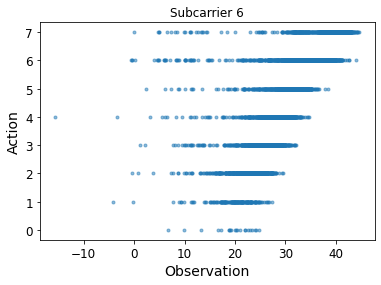

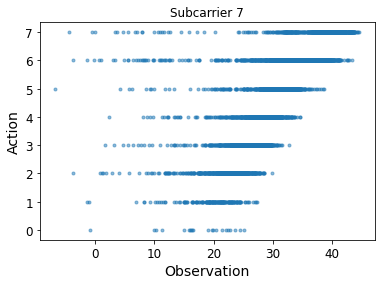

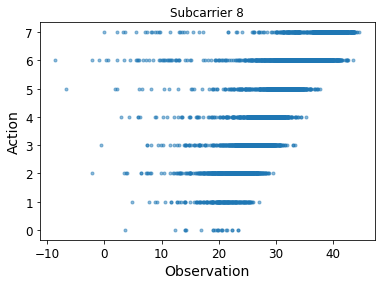

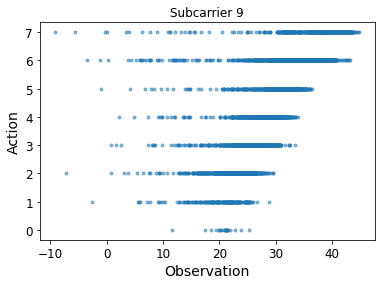

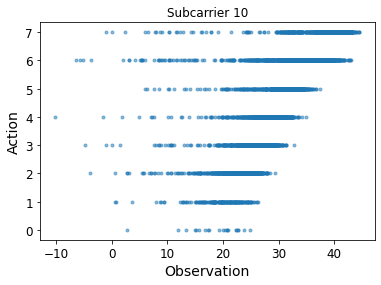

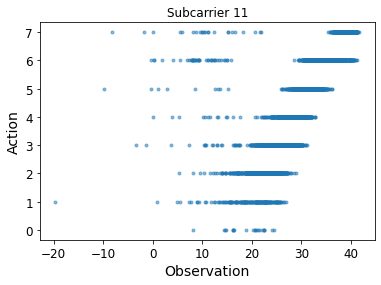

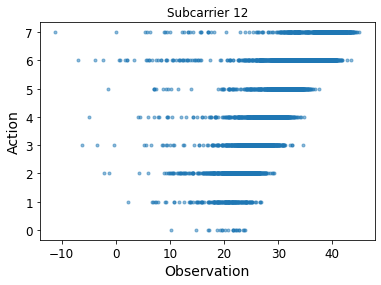

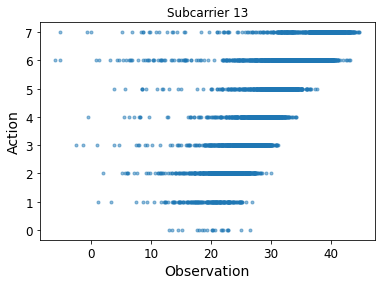

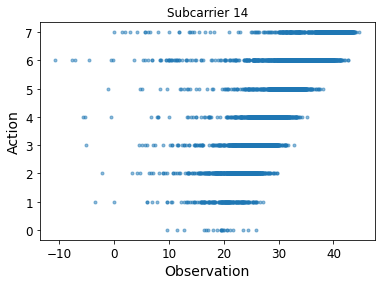

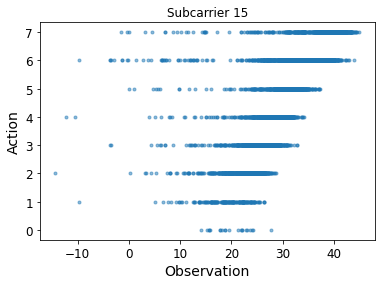

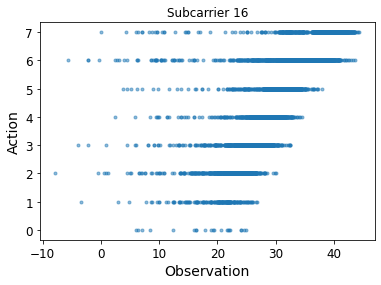

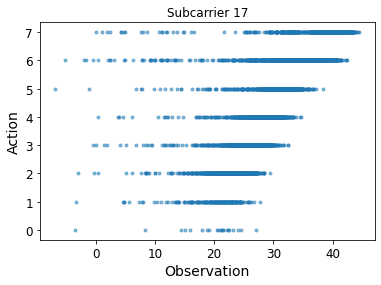

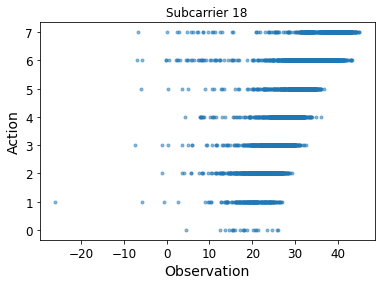

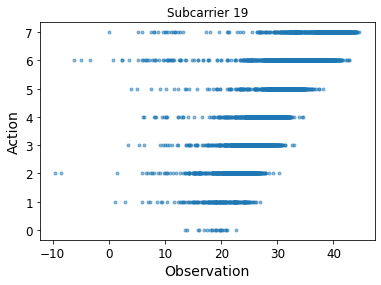

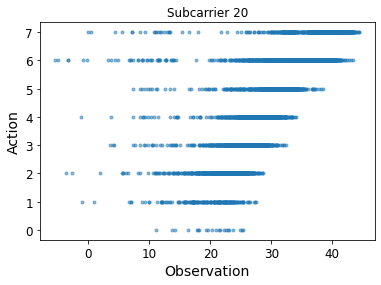

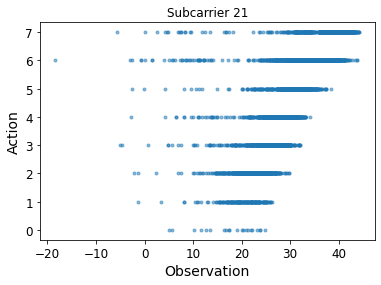

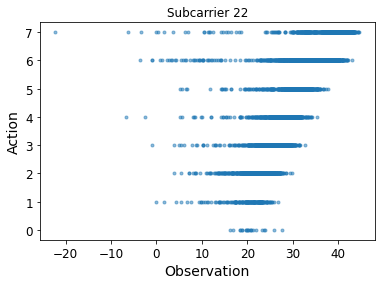

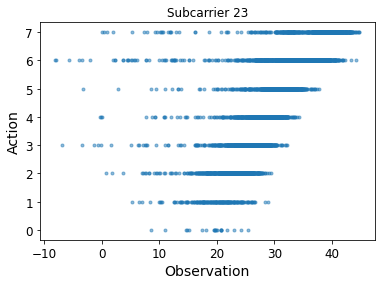

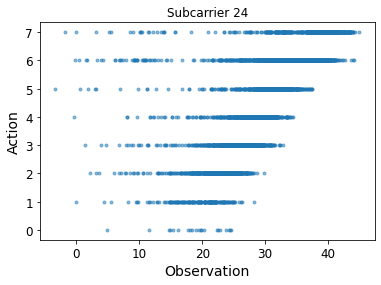

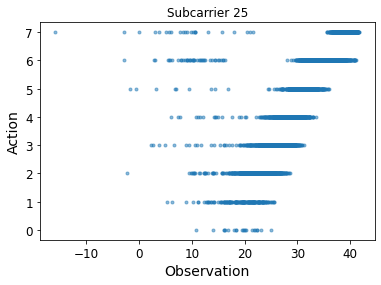

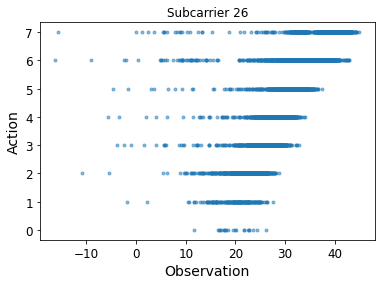

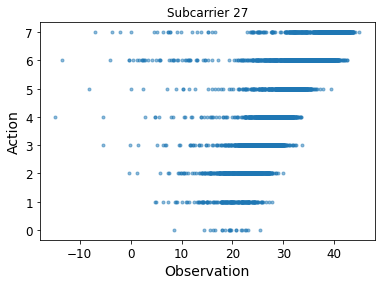

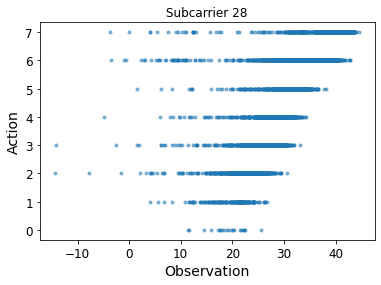

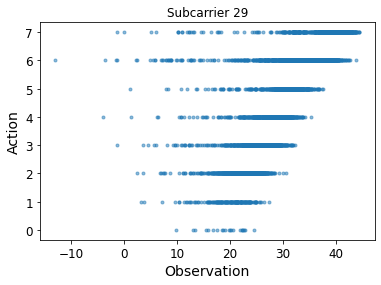

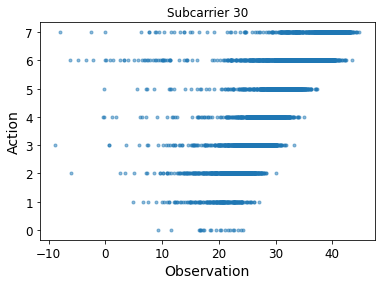

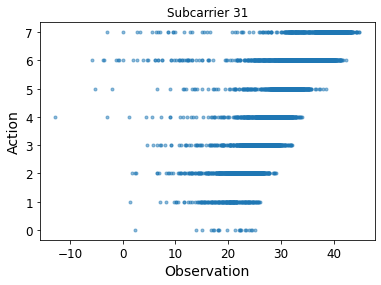

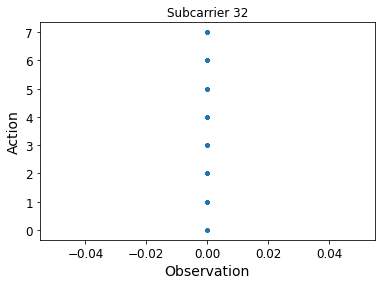

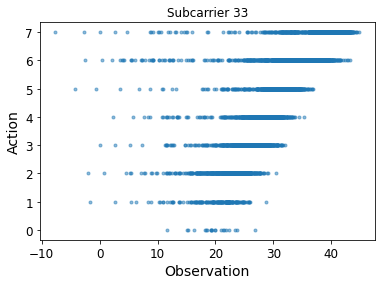

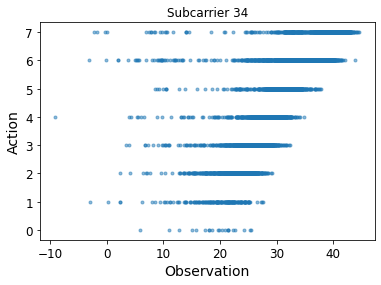

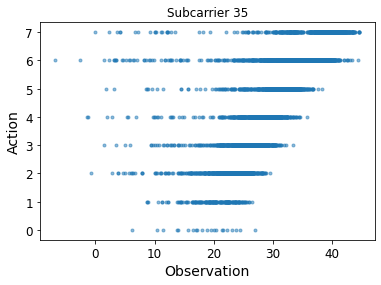

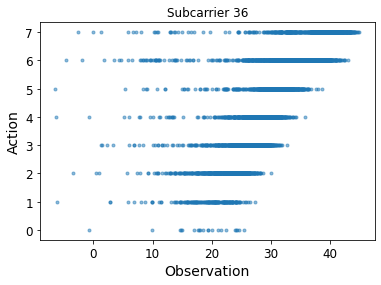

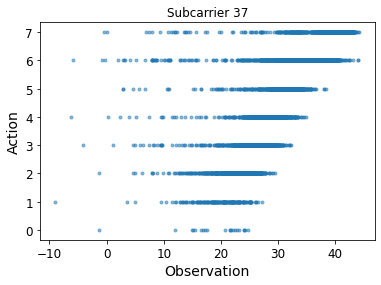

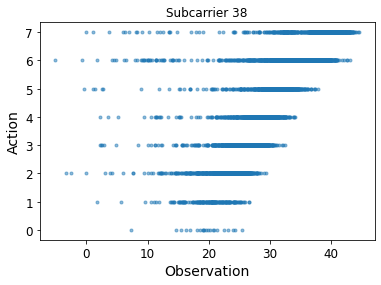

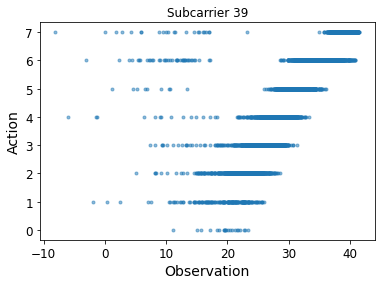

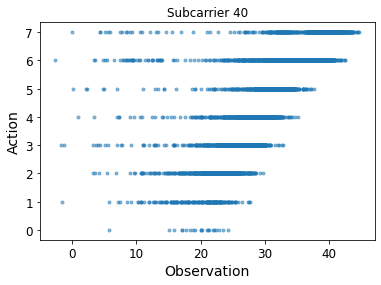

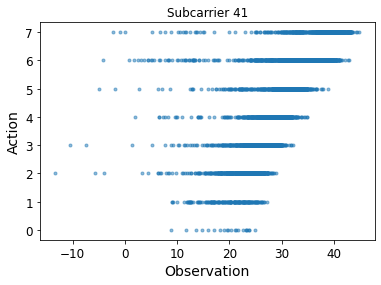

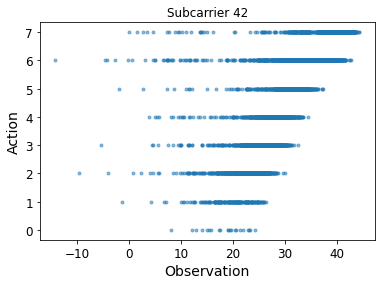

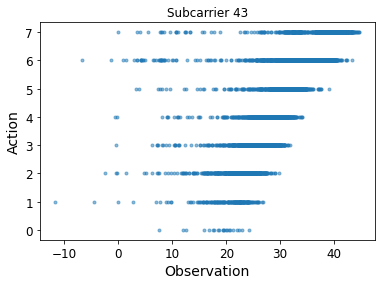

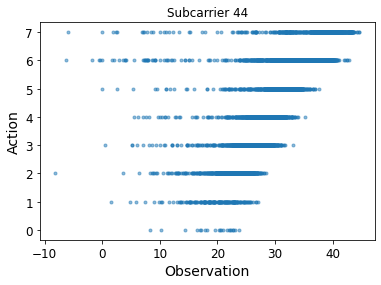

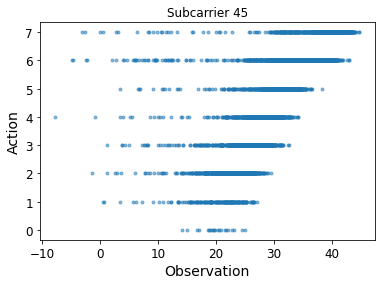

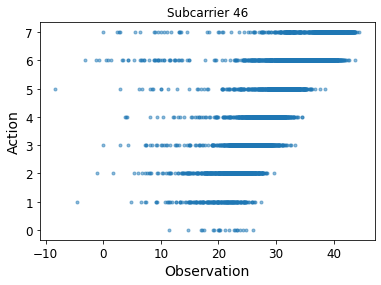

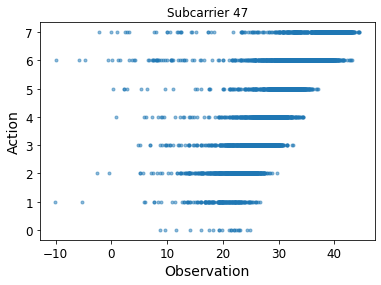

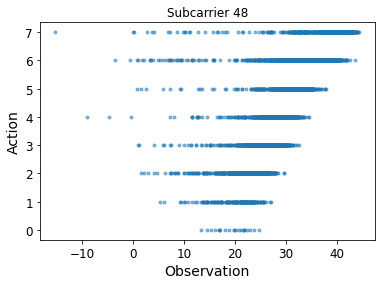

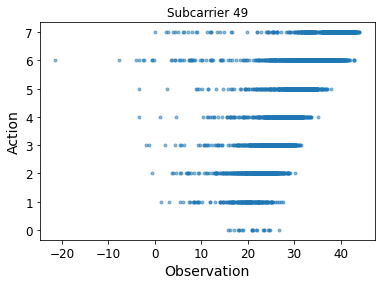

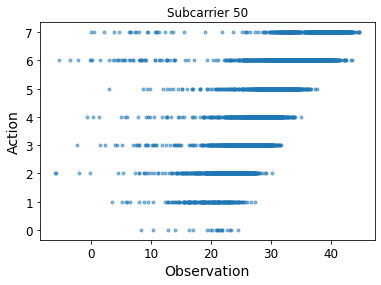

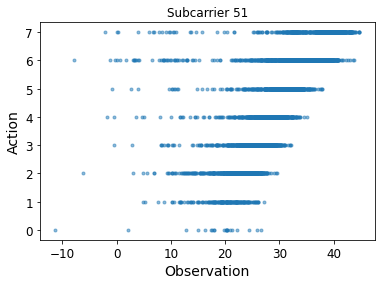

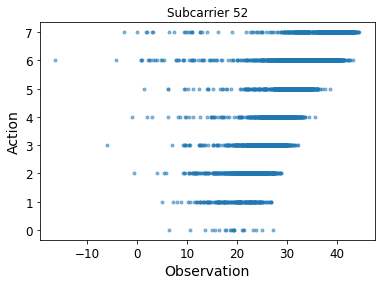

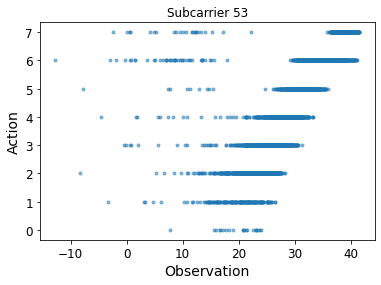

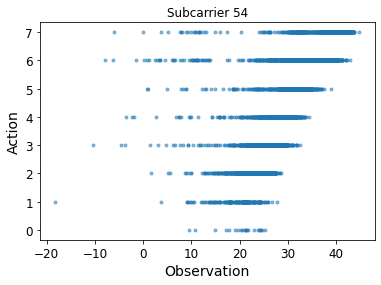

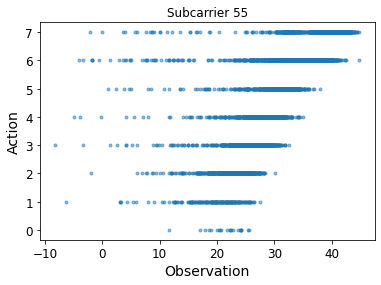

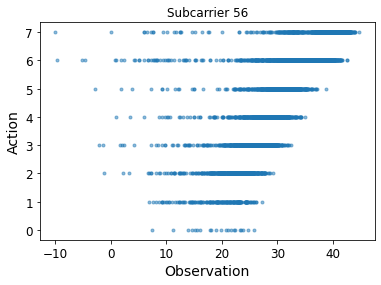

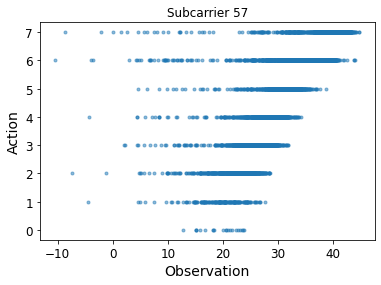

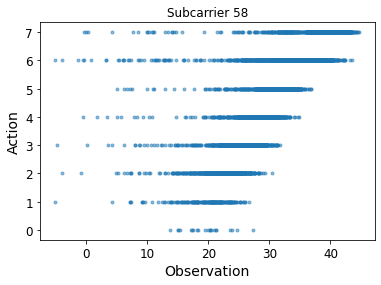

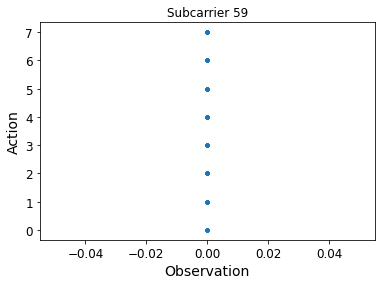

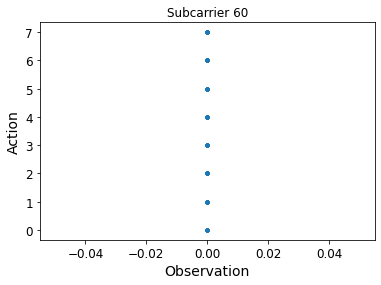

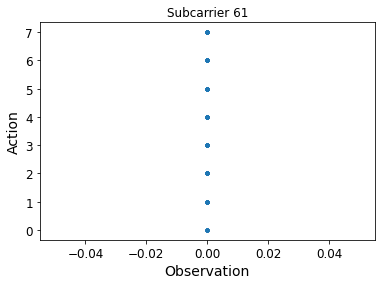

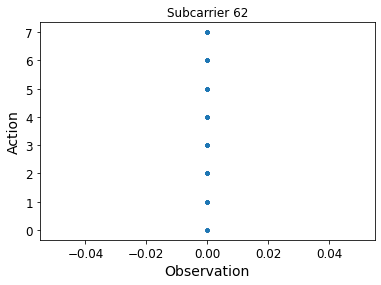

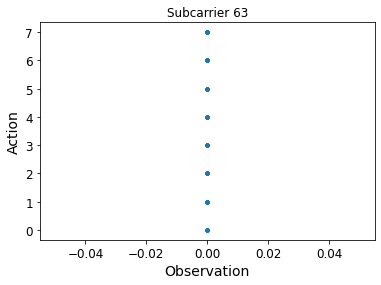

In [16]:
for i in range(64):
    plt.plot(df['Sc'+str(i)], df['Best'], '.', alpha = 0.5)
    plt.xlabel('Observation')
    plt.ylabel('Action')
    plt.title("Subcarrier " + str(i))
    plt.show()

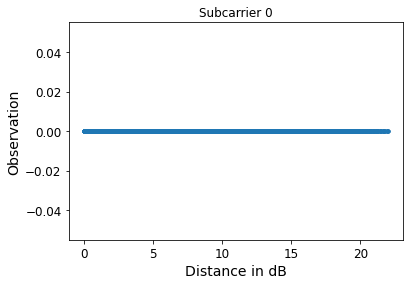

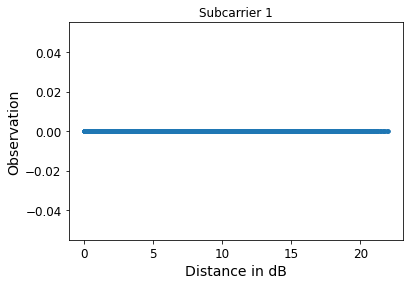

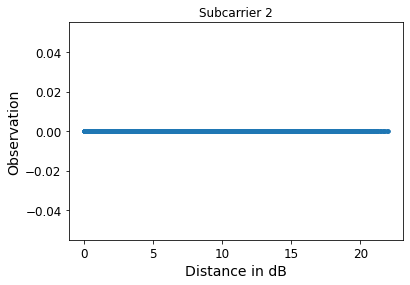

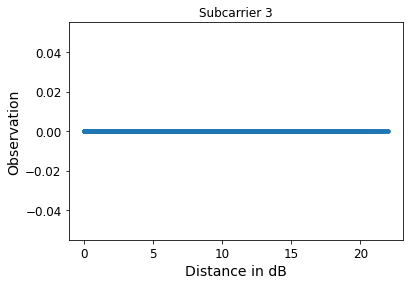

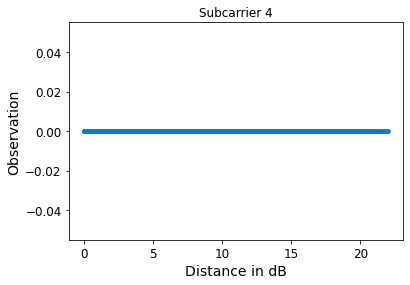

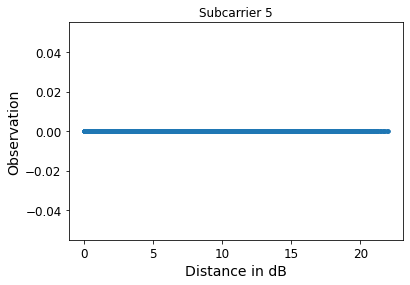

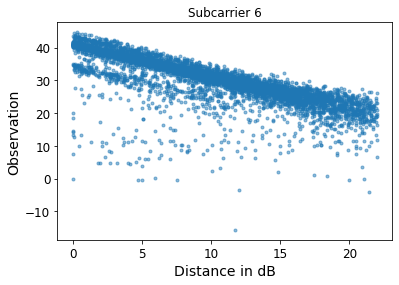

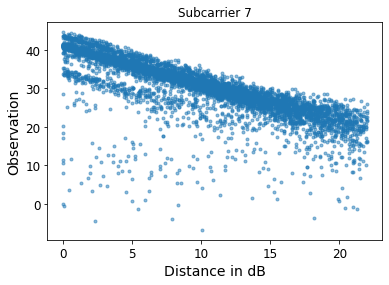

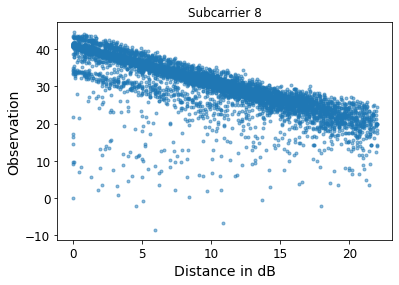

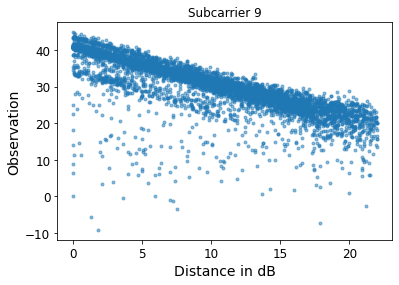

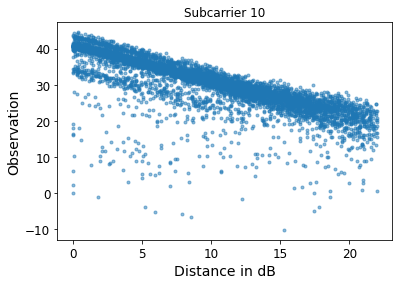

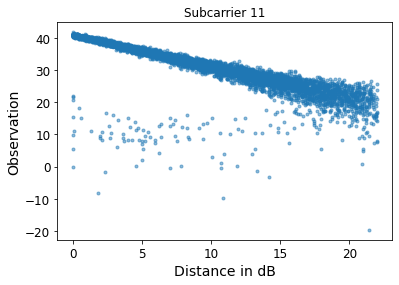

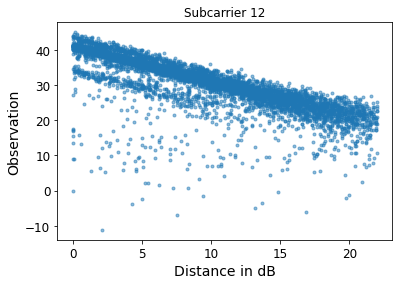

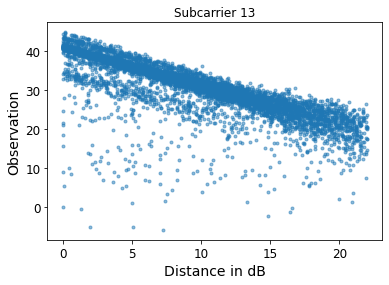

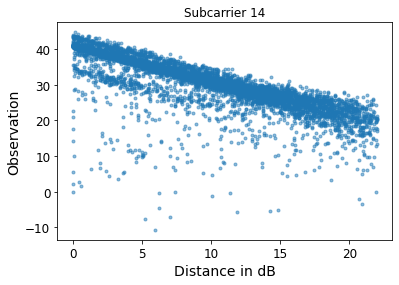

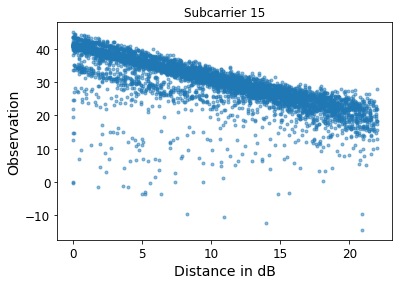

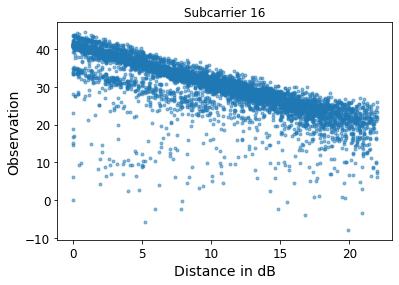

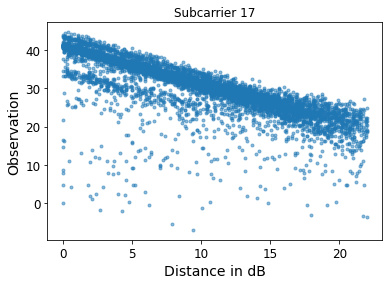

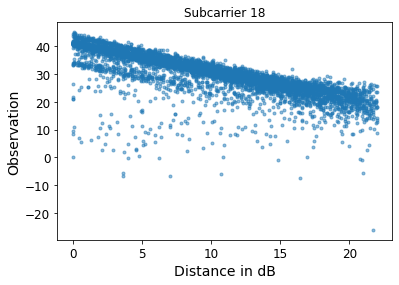

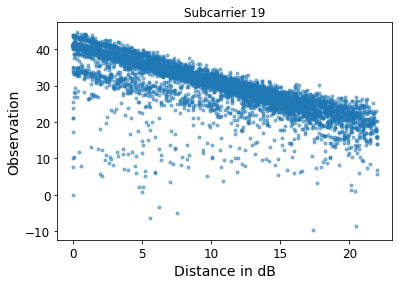

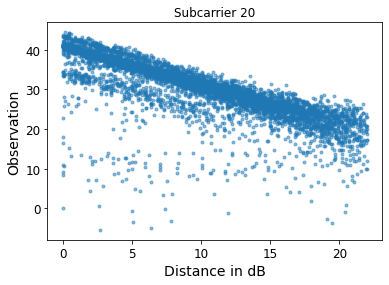

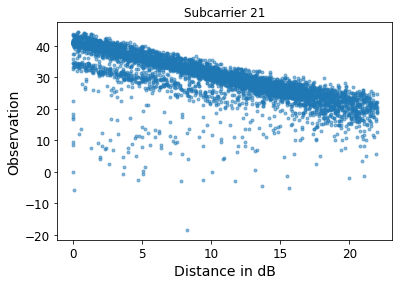

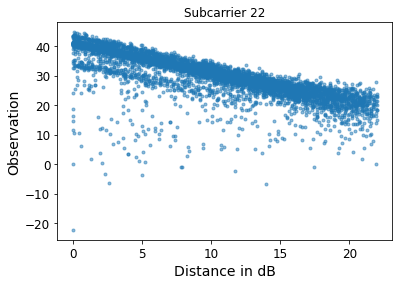

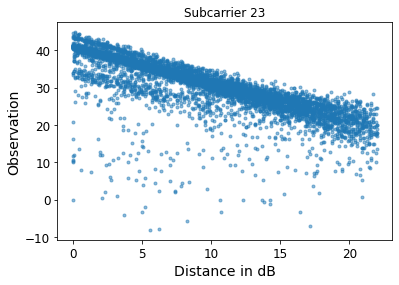

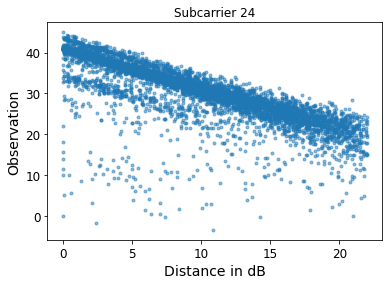

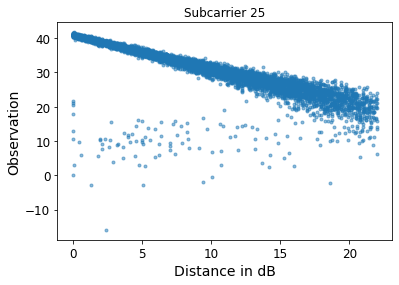

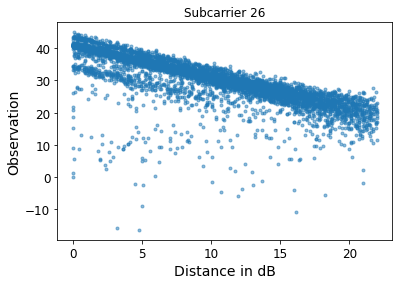

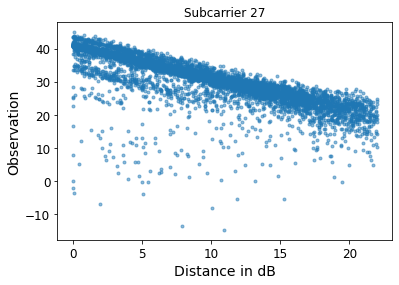

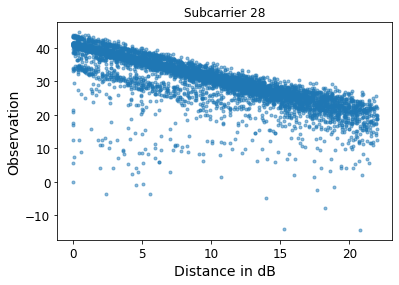

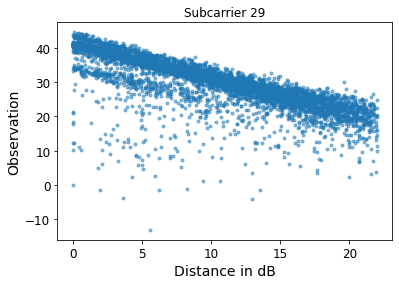

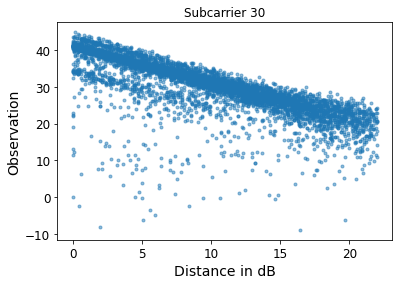

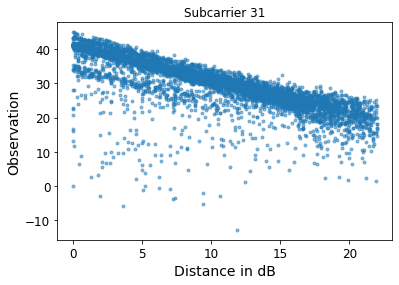

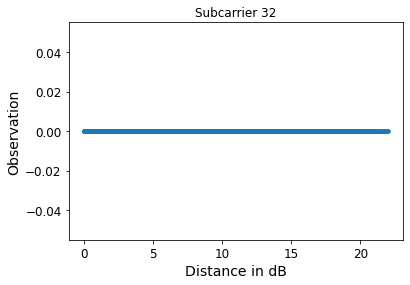

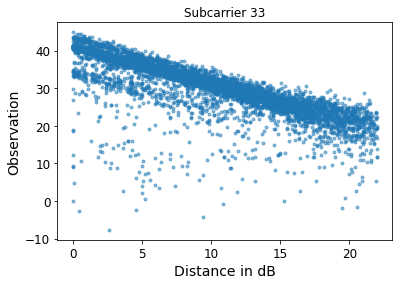

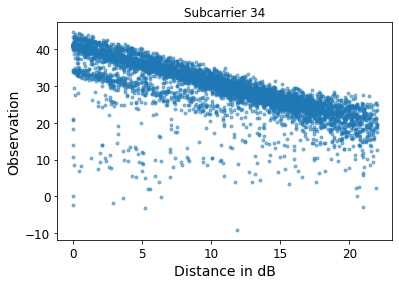

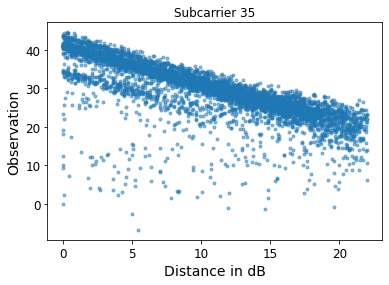

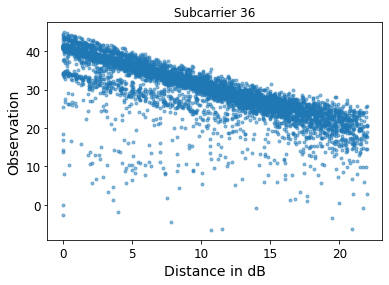

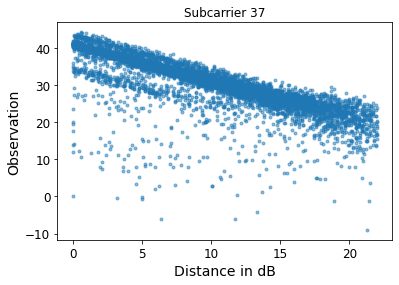

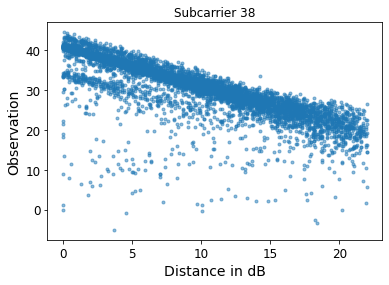

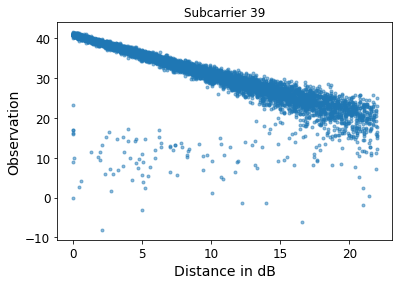

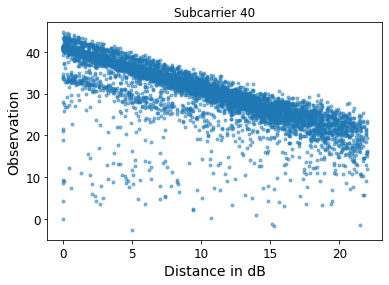

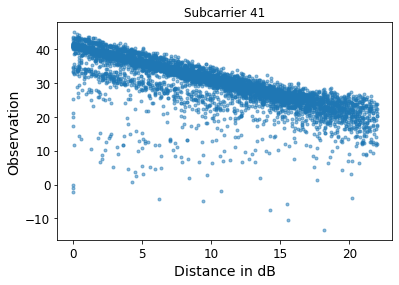

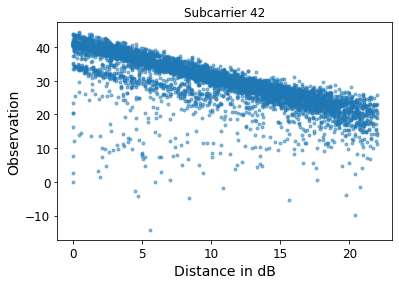

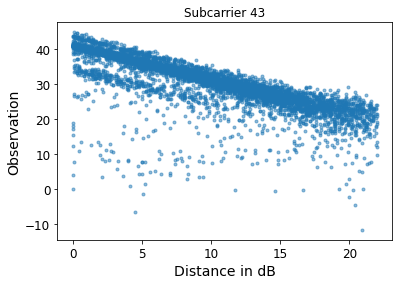

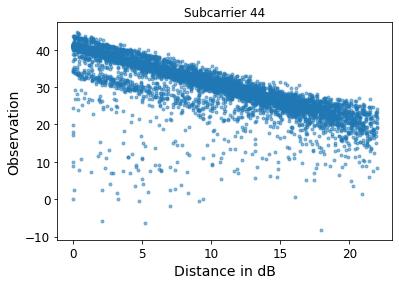

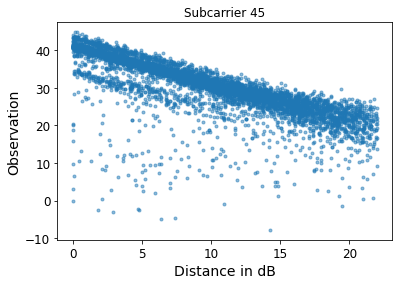

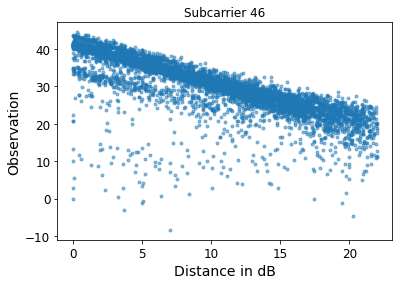

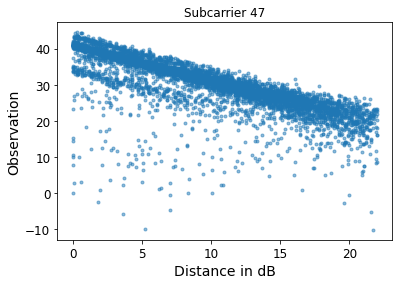

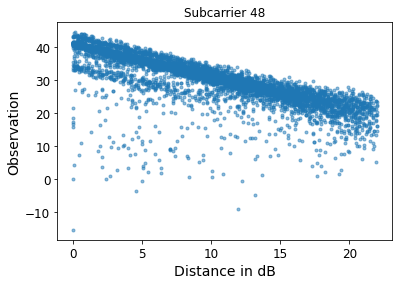

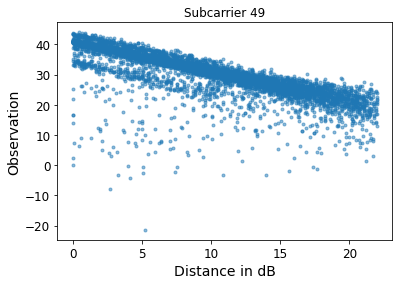

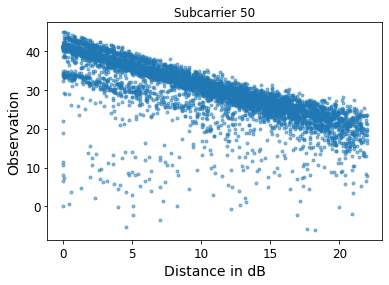

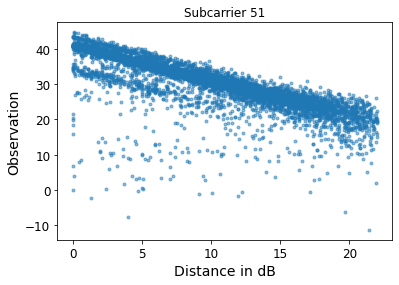

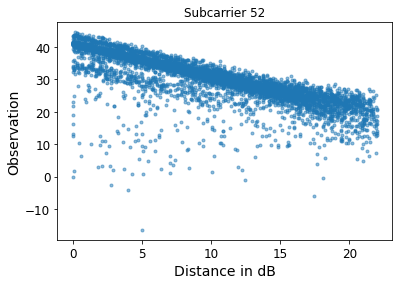

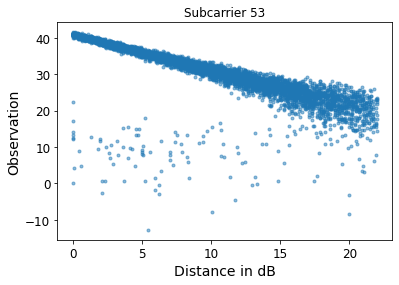

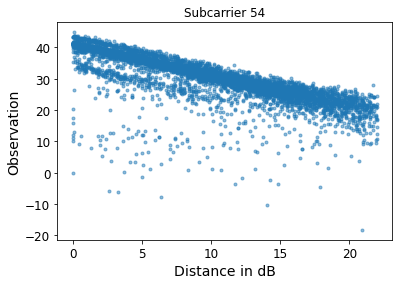

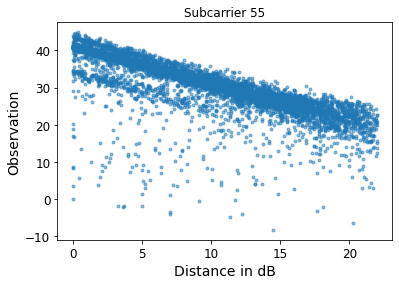

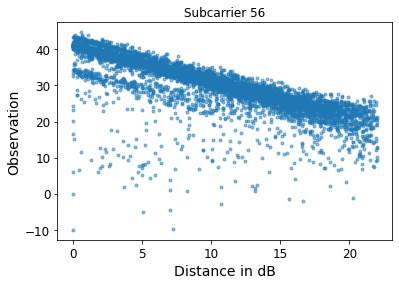

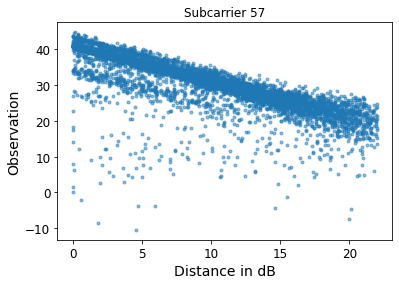

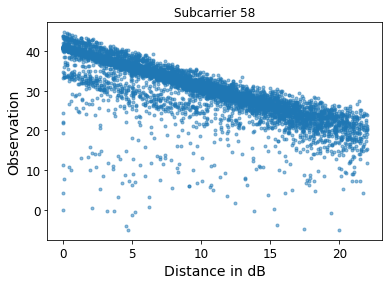

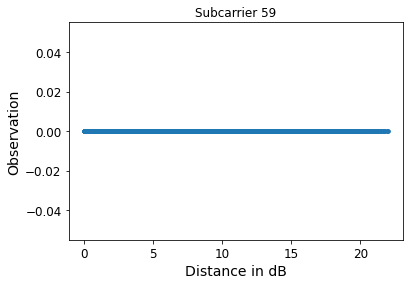

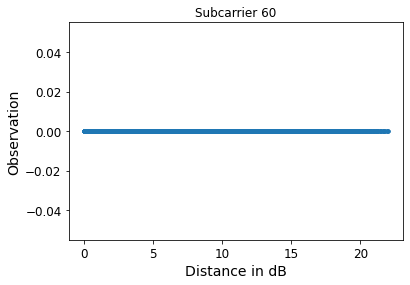

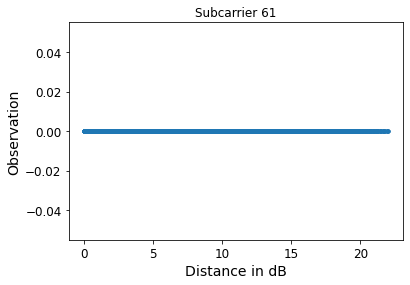

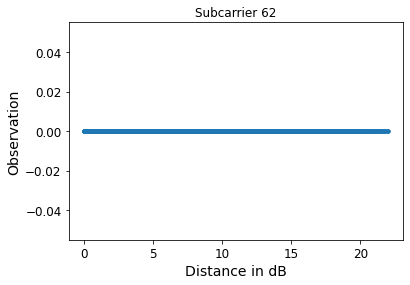

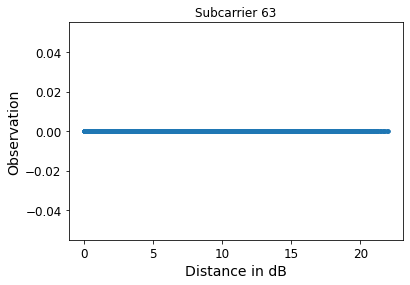

In [17]:
for i in range(64):
    plt.plot(df['Dist'], df['Sc'+str(i)], '.', alpha = 0.5)
    plt.xlabel('Distance in dB')
    plt.ylabel('Observation')
    plt.title("Subcarrier " + str(i))
    plt.show()